In [390]:
import torch
from IPython import display
from d2l import torch as d2l
import pandas as pd
import numpy as np
from pandas import DataFrame,Series



In [391]:
import os
print(os.path.abspath('.'))


C:\Users\86136\PycharmProjects\pythonProject\AI -learn from zero\softmax


In [392]:
#读取训练数据集 和  测试数据集
all_feature = pd.read_csv("../data/train_set.csv")
all_test = pd.read_csv("../data/test_set.csv")
# 先是pands类型的数据 进行数据切片 分为 数据和label  
# feature 是 float32  label 是长整型
feature = all_feature.iloc[:,0:-1].astype(np.float32)
label = all_feature.iloc[:,-1].astype(np.compat.long)

test_feature = all_test.iloc[:,0:-1].astype(np.float32)
test_label = all_test.iloc[:,-1].astype(np.compat.long)

In [393]:
# 把 俩个变量 feature 和 label 做成 list 
class GetLoader(torch.utils.data.Dataset):
	# 初始化函数，得到数据
    def __init__(self, data_root, data_label):
        self.data = data_root
        self.label = data_label
    # index是根据batchsize划分数据后得到的索引，最后将data和对应的labels进行一起返回
    def __getitem__(self, index):
        data = self.data[index]
        labels = self.label[index]
        return data, labels
    # 该函数返回数据大小长度，目的是DataLoader方便划分，如果不知道大小，DataLoader会一脸懵逼
    def __len__(self):
        return len(self.data)

In [394]:
# 再把np array 类型的数据转化为tensor 类型
feature = torch.tensor(feature.values)
label = torch.tensor(label.values).type(torch.long)

test_feature = torch.tensor(test_feature.values)
test_label = torch.tensor(test_label.values).type(torch.long)

In [395]:
#生成训练集和测试集
dataset = GetLoader(feature,label)

test_dataset = GetLoader(test_feature,test_label)

In [396]:
# 初始化权重（W）和偏置（b）
num_inputs = 70
num_outputs = 3

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

In [397]:
# 定义softmax函数 
# softmax的含义将 net 输出的矩阵的每一行 变化成 softmax的模式 
#意思是需要将一行的元素做e指数求和 再用每个元素的e指数来除以它
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition  # 这里应用了广播机制

In [398]:
# 这里的net之定义了一个矩阵的乘法
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

In [399]:
# 这里的是调试的需求
# y_hat=net(feature)
# y_hat = y_hat.argmax(axis=1)
# y_hat
# cmp = y_hat.type(label.dtype) ==label
# cmp

In [400]:
# 这里的cross_entrop 是作为损失函数
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])


In [401]:
#cross_entropy(y_hat,label)

In [402]:
#比较真实的输出 和 label 的比较结果
def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [403]:
#评估准确度 
# 测试模型的时候一般定义为eval（）模式  因为这个时候只进行前向的求导 不更新权重
#训练完train_datasets之后，model要来测试样本了。在model(test_datasets)之前，
#需要加上model.eval(). 否则的话，有输入数据，即使不训练，它也会改变权值。
#这是model中含有batch normalization层所带来的的性质。
def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式  
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [404]:
class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [405]:
evaluate_accuracy(net, dataset)

0.35

In [406]:
# update 雅传如 W，b lr 哈有batch_size
def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

In [407]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [408]:
lr =0.1
train_epoch_ch3(net,dataset,cross_entropy,updater)

(1.1076807937026023, 0.29875)

In [409]:
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [410]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 1],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

AssertionError: 0.85377186935395

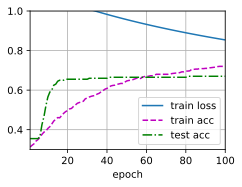

In [411]:
lr =0.2
batch_size = 40
num_epochs = 100
train_ch3(net, dataset, test_dataset, cross_entropy, num_epochs, updater)

In [ ]:
W